In [2]:
# Import necessary libraries
from keras.datasets import boston_housing

# Load the Boston Housing dataset
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
# Display the shapes of the training and test data
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [5]:
# Display the first 10 training targets in thousands of dollars
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [6]:
# Normalize the data by subtracting mean and dividing by standard deviation of each of the features
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [12]:
from keras import models
from keras import layers

# Function to build a simple neural network model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(units=64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dense(units=1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


In [13]:
import numpy as np

# Number of folds for k-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [14]:
from tqdm import tqdm
# Perform k-fold cross-validation
for i in tqdm(range (k)):
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i+1) *num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i+1) *num_val_samples:]], axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_loss, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

100%|██████████| 4/4 [02:06<00:00, 31.54s/it]


In [15]:
# Display the validation MAE scores for each fold
print(all_scores)

[2.214121103286743, 2.726698160171509, 2.5410232543945312, 2.667909622192383]


In [16]:
# Calculate the average validation MAE
np.mean(all_scores)

2.5374380350112915

In [18]:
# Increase the number of epochs for better analysis, will take some time
num_epochs = 500
all_mae_histories = []
# Perform k-fold cross-validation with extended epochs and record MAE history
for i in tqdm(range(k)):
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) *num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i + 1) *num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae = history.history['val_mae']
    all_mae_histories.append(mae)

100%|██████████| 4/4 [11:34<00:00, 173.53s/it]


In [21]:
# Average MAE over all epochs with comprehension
average_mae = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

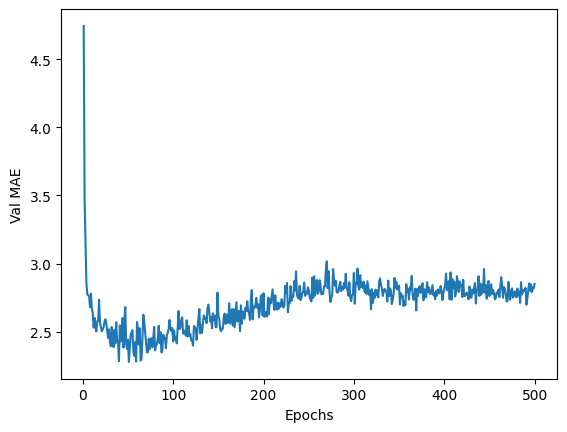

In [22]:
import matplotlib.pyplot as plt

# Plotting the validation MAE over epochs
plt.plot(range(1, len(average_mae) + 1), average_mae)
plt.xlabel('Epochs')
plt.ylabel('Val MAE')
plt.show()

In [27]:
# Function to smooth the curve for better visualization
def smooth_curve(points, smoothing_factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            prev_smooth = smoothed_points[-1]
            smoothed_points.append(prev_smooth * smoothing_factor + point * (1 - smoothing_factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

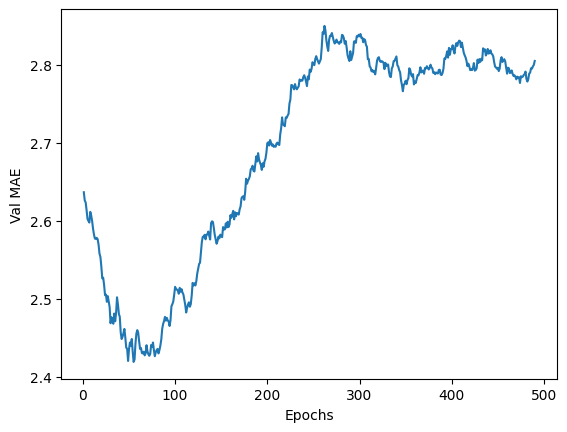

In [28]:
# Smoothed validation MAE curve
smoothed_points = smooth_curve(average_mae[10:])
plt.plot(range(1, len(smoothed_points) + 1), smoothed_points)
plt.xlabel('Epochs')
plt.ylabel('Val MAE')
plt.show()

In [35]:
# Train the final model with optimal number of epochs and evaluate on the test set
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16)
test_mse, test_mae = model.evaluate(test_data, test_targets)

Epoch 1/80
26/26 [==============================] - 0s 1ms/step - loss: 472.6081 - mae: 19.7706
Epoch 2/80
26/26 [==============================] - 0s 1ms/step - loss: 289.7953 - mae: 14.7737
Epoch 3/80
26/26 [==============================] - 0s 2ms/step - loss: 131.9763 - mae: 9.3805
Epoch 4/80
26/26 [==============================] - 0s 2ms/step - loss: 62.3635 - mae: 5.9950
Epoch 5/80
26/26 [==============================] - 0s 2ms/step - loss: 39.8102 - mae: 4.6083
Epoch 6/80
26/26 [==============================] - 0s 2ms/step - loss: 29.6495 - mae: 3.8479
Epoch 7/80
26/26 [==============================] - 0s 2ms/step - loss: 24.4207 - mae: 3.4706
Epoch 8/80
26/26 [==============================] - 0s 2ms/step - loss: 21.4755 - mae: 3.1979
Epoch 9/80
26/26 [==============================] - 0s 2ms/step - loss: 19.4628 - mae: 3.0359
Epoch 10/80
26/26 [==============================] - 0s 2ms/step - loss: 17.5786 - mae: 2.8928
Epoch 11/80
26/26 [==============================] - 0

In [36]:
# Display the final test MAE
test_mae

2.482614517211914